In [304]:
pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [305]:
import Bio

In [1]:
from Bio import SeqIO
for seq_record in SeqIO.parse('D:\GRCh38.primary_assembly.genome.fa', 'fasta'):
    if (seq_record.id == 'chr1'):
        my_seq_id = seq_record.id
        my_seq = (seq_record.seq)
        my_seq_len = len(seq_record)
        break

In [2]:
my_seq_id 

'chr1'

In [3]:
my_seq[0]

'N'

In [4]:
my_seq_len

248956422

In [5]:
import pandas as pd

In [6]:
col_index = ['chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', \
            'signalValue', 'pValue', 'qValue', 'peak']
C1_narrowPeak = pd.read_csv('C1.csv', sep = '\t')

In [7]:
C1_narrowPeak.columns = col_index
chr1 = C1_narrowPeak[(C1_narrowPeak.chrom == 'chr1')]
chr1_start = list(chr1.iloc[:, 1])
chr1_end = list(chr1.iloc[:,2])

In [8]:
C1_chr1_dna_seqs = []
for index in range(len(chr1_start)):
    C1_chr1_dna_seqs.append(str(my_seq)[chr1_start[index]: chr1_end[index]])

In [9]:
C2_narrowPeak = pd.read_csv('C2.csv', sep = '\t')
C2_narrowPeak.columns = col_index
chr1 = C2_narrowPeak[(C2_narrowPeak.chrom == 'chr1')]
chr1_start = list(chr1.iloc[:, 1])
chr1_end = list(chr1.iloc[:,2])

In [10]:
C2_chr1_dna_seqs = []
for index in range(len(chr1_start)):
    C2_chr1_dna_seqs.append(str(my_seq)[chr1_start[index]: chr1_end[index]])

In [11]:
chr1_dna_seqs = C1_chr1_dna_seqs + C2_chr1_dna_seqs
labels = [true]* len(C1_chr1_dna_seqs) + ['C2']* len(C2_chr1_dna_seqs)

In [12]:
dna_data = pd.DataFrame({'sequences': chr1_dna_seqs, 'label': labels})

In [13]:
dna_data.head()

,sequences,label
0,TCCACAAGGCTGAGTCAAATCTGCGTTTCATCATCTATAAGAAAGG...,C1
1,GGCGGAGGGAAGGACGGGGAAGCATCTCAGGGAGGACTGGCGTCTG...,C1
2,CTTTCTCAGTGTCTTCAAGAATAAAATGCCTCCGTTGTTGGTTTTA...,C1
3,TATGTCCCATGCAGCCTGATGAAGGGTAAAAAAGAGCCCAATGCAG...,C1
4,TGAAGGCCTGGTTTCCACCGAAGCTCTCACAGCCCAGCCTTTCACT...,C1


In [485]:
def getKmers(seq, size=3):
    return [seq[i: i+size].lower() for i in range(0, len(seq) - size + 1)]

In [486]:
dna_data['words'] = dna_data.apply(lambda x: getKmers(x['sequences']), axis = 1)

In [487]:
dna_data = dna_data.drop('sequences', axis = 1)

In [488]:
dna_data.head()

,label,words
0,C1,"[tcc, cca, cac, aca, caa, aag, agg, ggc, gct, ..."
1,C1,"[ggc, gcg, cgg, gga, gag, agg, ggg, gga, gaa, ..."
2,C1,"[ctt, ttt, ttc, tct, ctc, tca, cag, agt, gtg, ..."
3,C1,"[tat, atg, tgt, gtc, tcc, ccc, cca, cat, atg, ..."
4,C1,"[tga, gaa, aag, agg, ggc, gcc, cct, ctg, tgg, ..."


In [489]:
dna_texts = list(dna_data['words'])
for elem in range(len(dna_texts)):
    dna_texts[elem] = ' '.join(dna_texts[elem])
label_class = dna_data.iloc[:, 0].values

In [490]:
from sklearn.feature_extraction.text import CountVectorizer

In [491]:
cv = CountVectorizer(ngram_range = (4,4))
X = cv.fit_transform(dna_texts)

In [492]:
print(X.shape)

(25343, 4096)


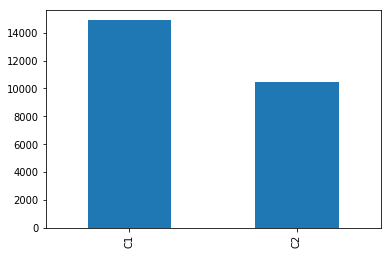

In [493]:
dna_data['label'].value_counts().sort_index().plot.bar()

In [523]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, label_class, 
                                test_size = 0.1, random_state = 42)

In [524]:
print(X_train.shape, X_test.shape)

(22808, 4096) (2535, 4096)


In [540]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha = 0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [541]:
y_pred = classifier.predict(X_test)

In [548]:
z = [True if y_pred[i] == y_test[i] else False for i in range(len(y_pred))]

In [547]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name='Predicted')))
def get_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix

Predicted    C1   C2
Actual              
C1         1100  423
C2          620  392
accuracy = 0.589 
precision = 0.576 
recall = 0.589 
f1 = 0.579


In [545]:
accuracy_score?